In [0]:
import torch
import torchvision
from torch import optim
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import json
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install pillow
!pip install numpy

tcmalloc: large alloc 1073750016 bytes == 0x581e6000 @  0x7f47e79f02a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
img_size = 224

In [0]:
if not os.path.exists("flower_data") :
  !wget -c https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
  !unzip flower_data.zip
else:
  print('Data has already been downloaded')


Data has already been downloaded


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])


test_transforms = transforms.Compose([transforms.Resize(img_size+1),
                                      transforms.CenterCrop(img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])])


In [0]:
# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)

In [0]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64) 

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def configure_model(structure = 'densenet121', hidden_layer=512, dropout = 0.2, lr=0.003):
  # Freeze parameters so we don't backprop through them
    if structure == 'densenet121':
      model = models.densenet121(pretrained=True)
    else:
      print('Sorry, expecting model to be dense121')
      
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(nn.Linear(1024, hidden_layer),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(hidden_layer, 102),
                                     nn.LogSoftmax(dim=1))

    criterion = nn.NLLLoss()
    
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
    model.to(device);
    
    return model , optimizer ,criterion 

model , optimizer ,criterion = configure_model('densenet121')

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
epochs = 20

# track change in validation loss
valid_loss_min = np.Inf

###################
# train the model #
###################

model.train()

for epoch in range(epochs):
  
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    for data, labels in train_loader:
        # Move input and label tensors to the default device
        data, labels = data.to(device), labels.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
            
            
    ######################    
    # validate the model #
    ######################

    model.eval()
    with torch.no_grad():
        for data, labels in valid_loader:
            data, labels = data.to(device), labels.to(device)
            
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, labels)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            model.class_to_idx = train_data.class_to_idx
            model.cpu
            
            # TODO: Save the checkpoint 
            torch.save({'structure' :'densenet121',
                        'hidden_layer':512,
                        'epochs': epoch + 1,
                        'state_dict':model.state_dict(),
                        'validation_loss': valid_loss,
                        'training_loss': train_loss,
                        'optimizer': optimizer,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'class_to_idx': model.class_to_idx},'checkpoint.path')
            valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 2.561433 	Validation Loss: 0.323077 
Validation loss decreased (inf --> 0.323077).  Saving model ...
Epoch: 1 	Training Loss: 0.983127 	Validation Loss: 0.191893 
Validation loss decreased (0.323077 --> 0.191893).  Saving model ...
Epoch: 2 	Training Loss: 0.672590 	Validation Loss: 0.176904 
Validation loss decreased (0.191893 --> 0.176904).  Saving model ...
Epoch: 3 	Training Loss: 0.563151 	Validation Loss: 0.148145 
Validation loss decreased (0.176904 --> 0.148145).  Saving model ...
Epoch: 4 	Training Loss: 0.499447 	Validation Loss: 0.135012 
Validation loss decreased (0.148145 --> 0.135012).  Saving model ...
Epoch: 5 	Training Loss: 0.463925 	Validation Loss: 0.137006 
Epoch: 6 	Training Loss: 0.443327 	Validation Loss: 0.118082 
Validation loss decreased (0.135012 --> 0.118082).  Saving model ...
Epoch: 7 	Training Loss: 0.424429 	Validation Loss: 0.116925 
Validation loss decreased (0.118082 --> 0.116925).  Saving model ...
Epoch: 8 	Training Loss: 0

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path):
    checkpoint = torch.load(path)
    structure = checkpoint['structure']
    hidden_layer = checkpoint['hidden_layer']
    model,_,_ = configure_model(structure ,hidden_layer)
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    
load_model('checkpoint.path')  

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
# TODO: Do validation on the test set
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model.to('cuda:0')
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
check_accuracy_on_test(test_loader)

Accuracy of the network on the test images: 88 %


In [0]:

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
   
    img_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = img_transforms(img)
    
    return img_tensor
    

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.'''
    
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

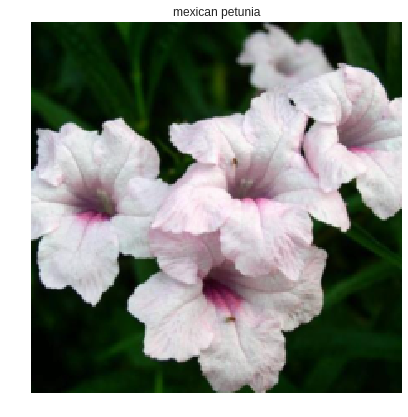

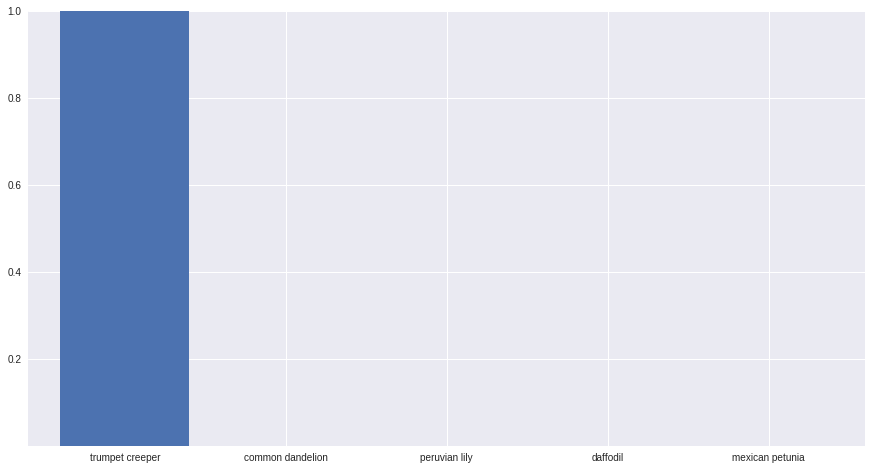

In [0]:
# TODO: Display an image along with the top 5 classes
def check_sanity(path):
    plt.rcParams["figure.figsize"] = (20,15)
    plt.subplot(211)
    
    probabilities = predict(path, model)
    image = process_image(path)
    probabilities = probabilities
    
    index = path.split('/')[2]
    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(15,8))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)

    plt.show()
    
check_sanity('flower_data/train/98/image_07751.jpg')